In [32]:
library(dplyr)
library(parallel)
library(stringr)

reprocess_switch=1 #0 or 1. 1 means to recreate all reach and node products following some change in processing. 
#0 means to just append to existing dataframes

# hubname='UNC'
# rivername='WK'
# continent='oc'
# PT_key_file= 'WK_Key_20230331.csv' #WK
# utm_zone='58 +south'#WK='58 +south'

# hubname='UMass'
# rivername='CR'
# continent='na'
# PT_key_file='Key_CR_FS_20230322.csv' #CT
# utm_zone=18 #Ct= 18

hubname='CU'
rivername='WM'
continent='na'
PT_key_file= 'SWOTCalVal_WM_KEY_20230326.csv' #WM
utm_zone=10 #WM= 10


buffer=500 #m, 'extends' the reach

setwd(paste0('/nas/cee-water/cjgleason/calval/Processed data/',hubname,'/'))
domain_file=keyfile=paste0(rivername,'_domain.csv')

#PT paths---------
PT_data_directory='Raw PT/'
QA_QC_PT_output_directory='Munged PT/'
flagged_PT_output_directory='Flagged PT/'
#--------------------------------------------------

#drift paths------------------------------------------
GNSS_drift_data_directory=paste0('From Andy/',hubname,'_netCDFs/')
if(reprocess_switch==1){
    dir.create(paste0('Munged drifts/','reprocessed_',  str_replace_all(as.character(Sys.Date()),'\\-','_')))
    QA_QC_drift_output_directory=paste0('Munged drifts/','reprocessed_',  str_replace_all(as.character(Sys.Date()),'\\-','_'),'/')
    
    dir.create(paste0('Data frames/','reprocessed_',  str_replace_all(as.character(Sys.Date()),'\\-','_')))
     dir.create(paste0('Data frames/','reprocessed_',  str_replace_all(as.character(Sys.Date()),'\\-','_'),'/node'))
    dir.create(paste0('Data frames/','reprocessed_',  str_replace_all(as.character(Sys.Date()),'\\-','_'),'/reach'))
    reachnode_output_directory=paste0('Data frames/','reprocessed_',  str_replace_all(as.character(Sys.Date()),'\\-','_'),'/')
    
    } else {
    
folderlist= list.files('Munged drifts',full.names = TRUE)
    
foldertimes=file.info(folderlist)%>%
 mutate(mintime= Sys.time()-mtime) %>%
 filter(mintime== min(mintime)) 
    
QA_QC_drift_output_directory=row.names(foldertimes)
    
folderlist2= list.files('Data frames',full.names = TRUE)
    
foldertimes2=file.info(folderlist2)%>%
 mutate(mintime= Sys.time()-mtime) %>%
 filter(mintime== min(mintime)) 
    
reachnode_output_directory=row.names(foldertimes2)
    
}

flagged_drift_output_directory='Flagged drifts/'
#--------------------------------------------------

#sword paths----------------------------------------
SWORD_path=paste0('/nas/cee-water/cjgleason/calval/SWORD_15/netcdf/',continent,
                  '_sword_v15.nc')
munged_drift_directory='Munged drifts/'
PT_directory='Munged PTs/'
#------------------------------



[1] "Munged drifts/reprocessed_2023_05_09/SWOTCalVal_WM_GNSS_L2_Rec3_20230404T173715_20230404T225120_20230426T012632.csv"


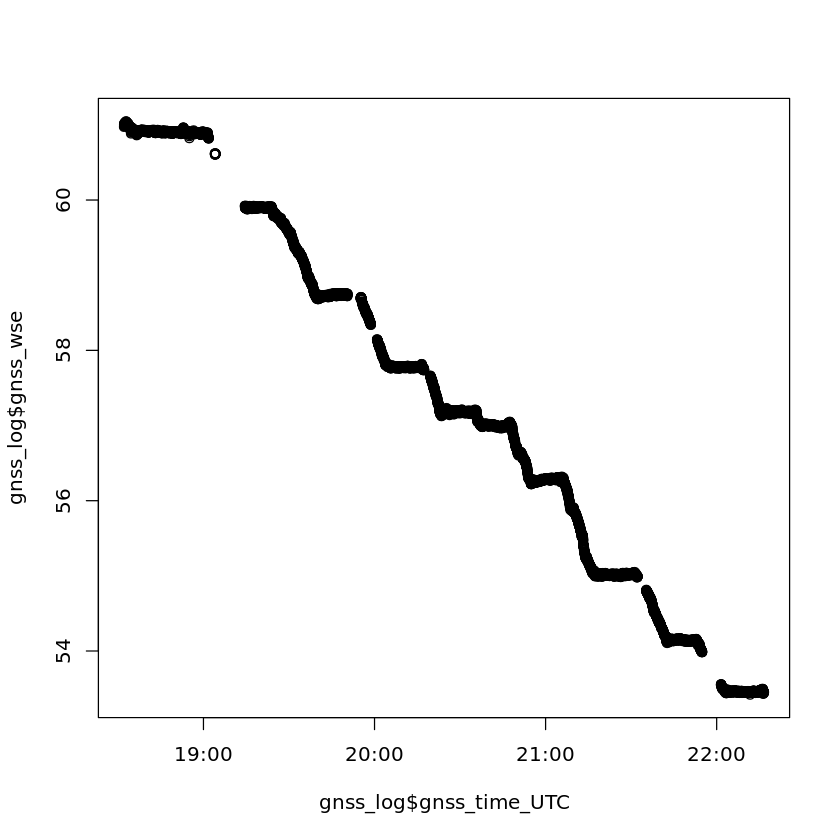

[1] "Munged drifts/reprocessed_2023_05_09/SWOTCalVal_WM_GNSS_L2_Rec3_20230405T163220_20230405T223914_20230426T014921.csv"


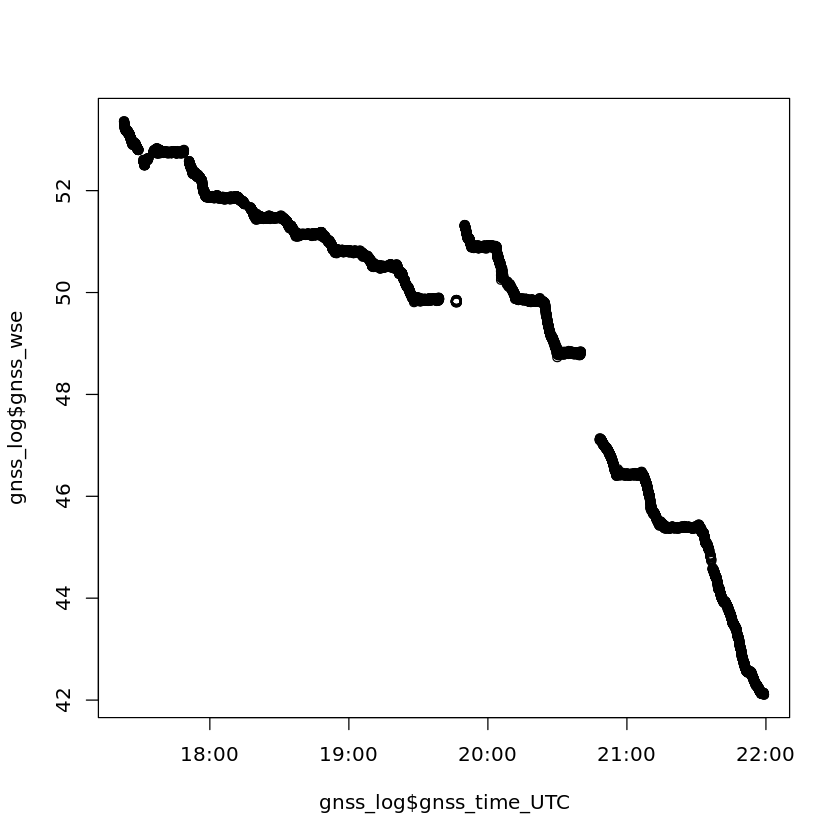

[1] "Munged drifts/reprocessed_2023_05_09/SWOTCalVal_WM_GNSS_L2_Rec3_20230406T162215_20230406T200804_20230426T021617.csv"


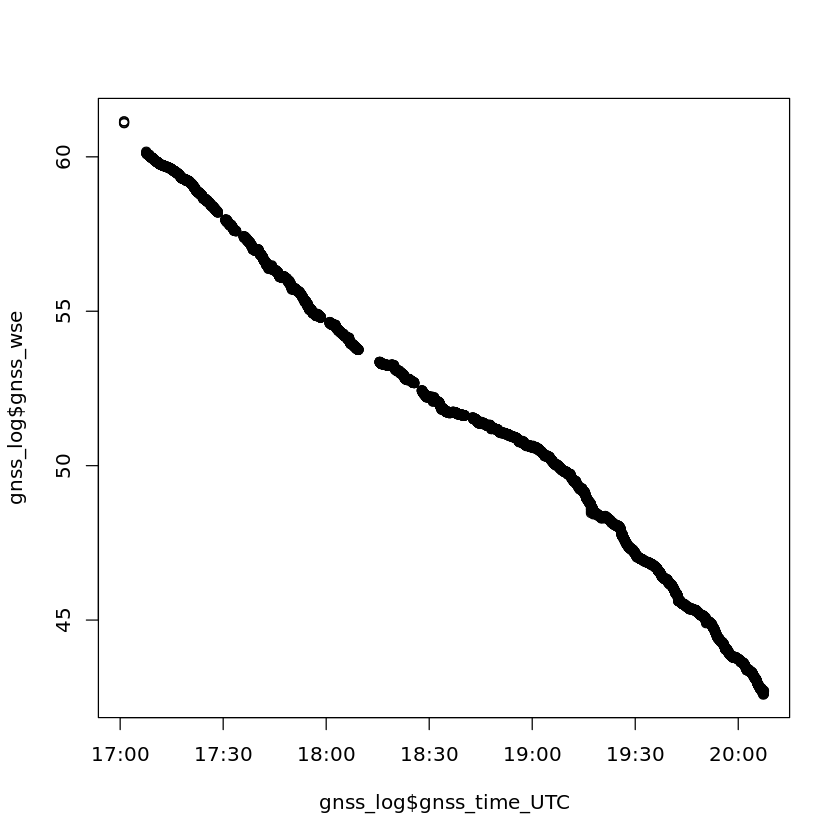

[1] "Munged drifts/reprocessed_2023_05_09/SWOTCalVal_WM_GNSS_L2_Rec3_20230412T173325_20230412T220700_20230426T023440.csv"


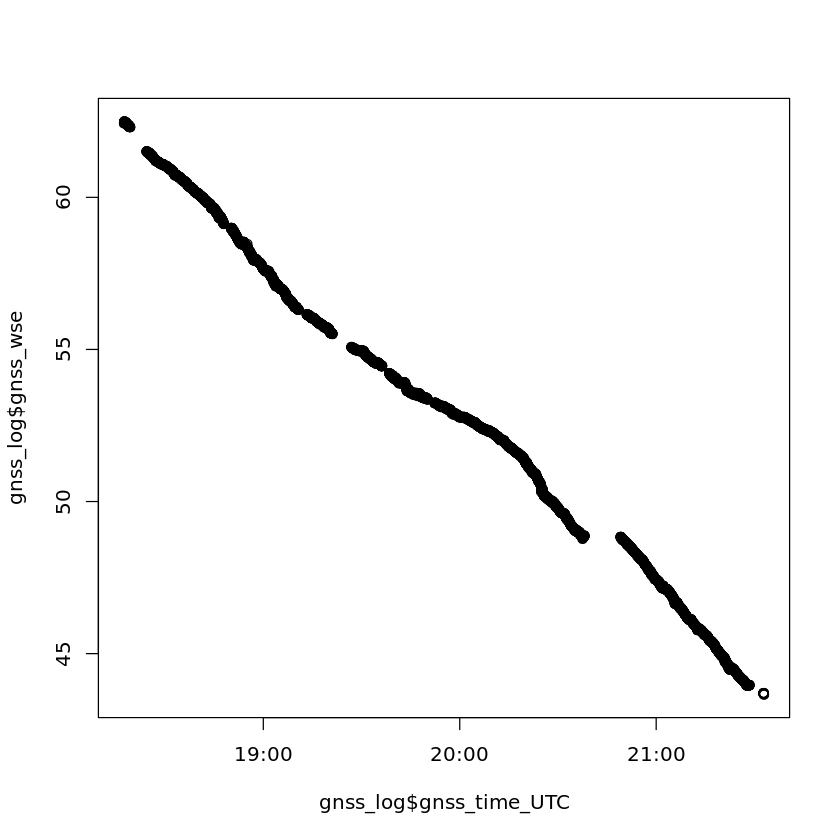

[1] "Munged drifts/reprocessed_2023_05_09/SWOTCalVal_WM_GNSS_L2_Rec3_20230413T162058_20230413T210340_20230426T025448.csv"


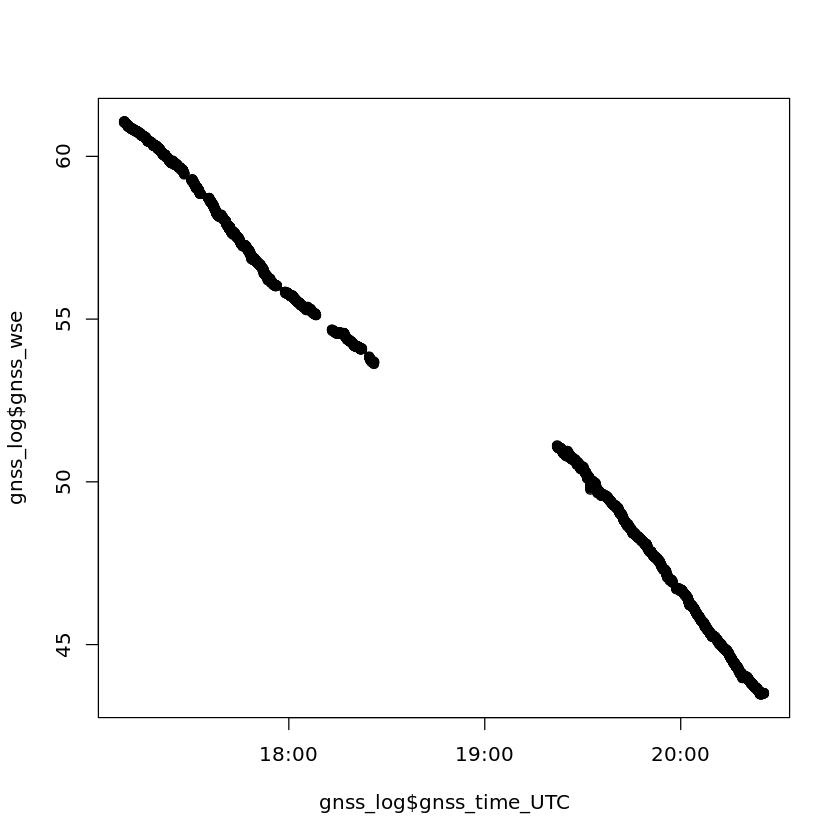

[1] "Munged drifts/reprocessed_2023_05_09/SWOTCalVal_WM_GNSS_L2_Rec3_20230414T155545_20230414T201340_20230426T031340.csv"


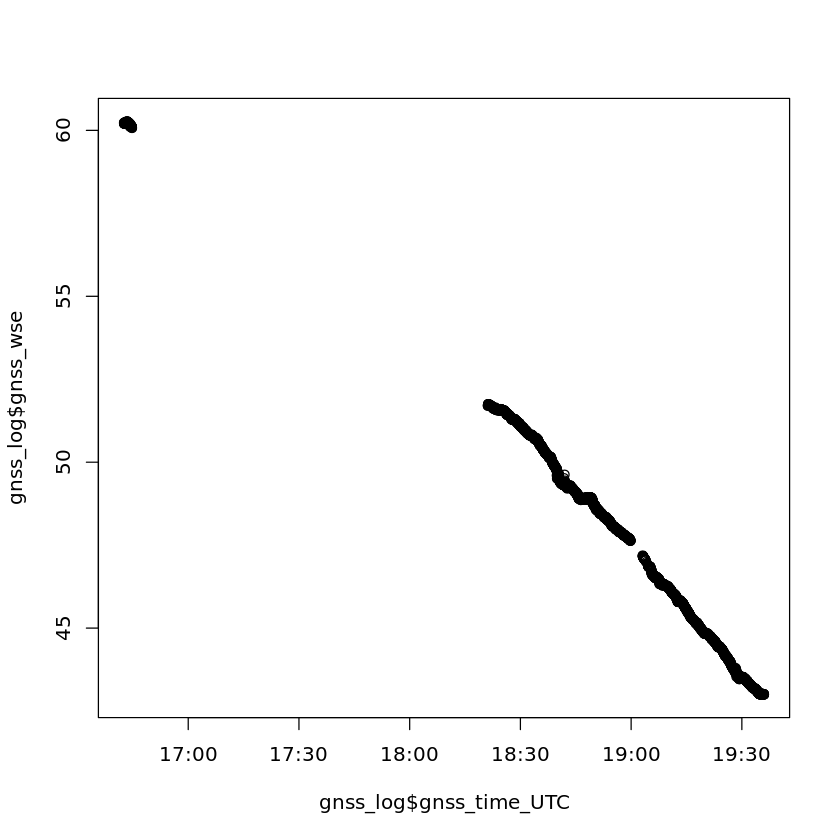

[1] "Munged drifts/reprocessed_2023_05_09/SWOTCalVal_WM_GNSS_L2_Rec3_20230418T173510_20230418T220130_20230426T032953.csv"


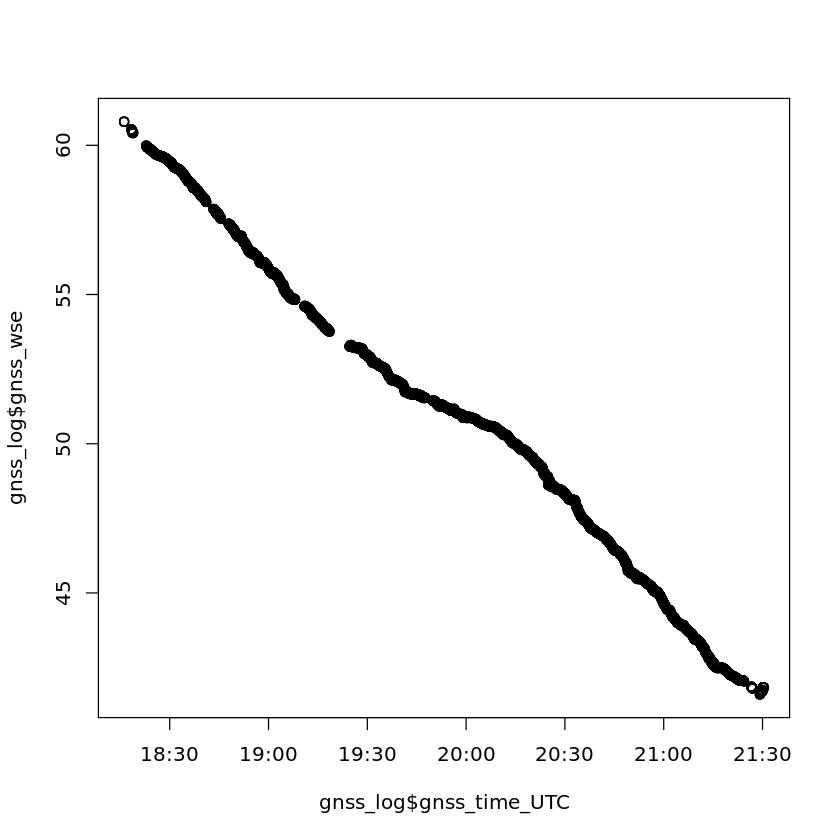

[1] "Munged drifts/reprocessed_2023_05_09/SWOTCalVal_WM_GNSS_L2_Rec3_20230419T165830_20230419T211549_20230426T034753.csv"


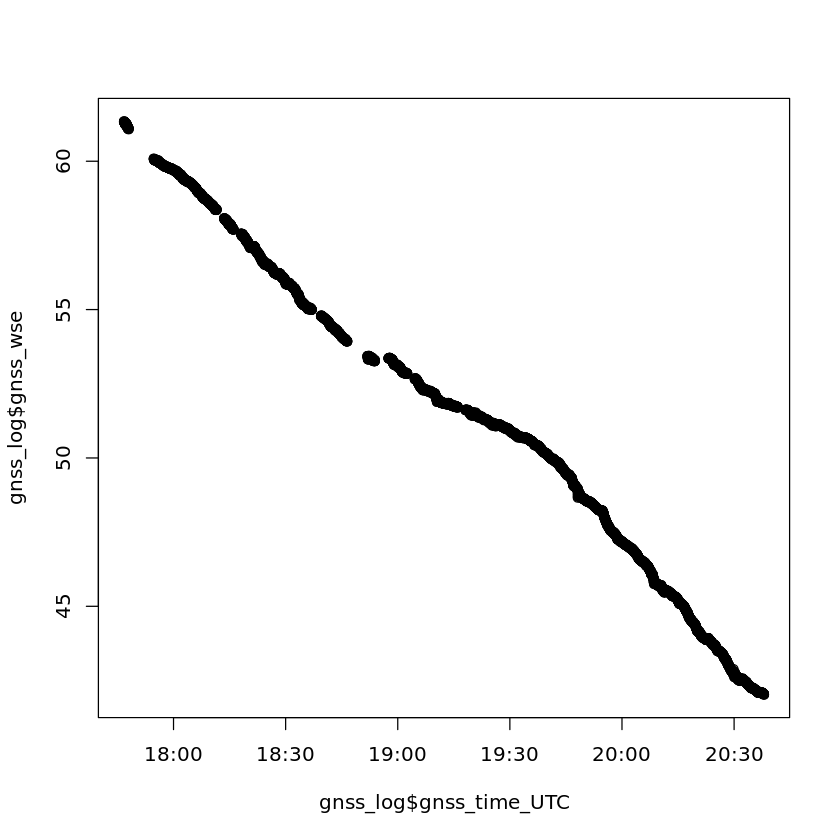

[1] "Munged drifts/reprocessed_2023_05_09/SWOTCalVal_WM_GNSS_L2_Rec3_20230420T175630_20230420T223650_20230426T040723.csv"
[1] "filename SWOTCalVal_WM_GNSS_L2_Rec3_20230421T163420_20230421T211530_20230426T042740 bonked"


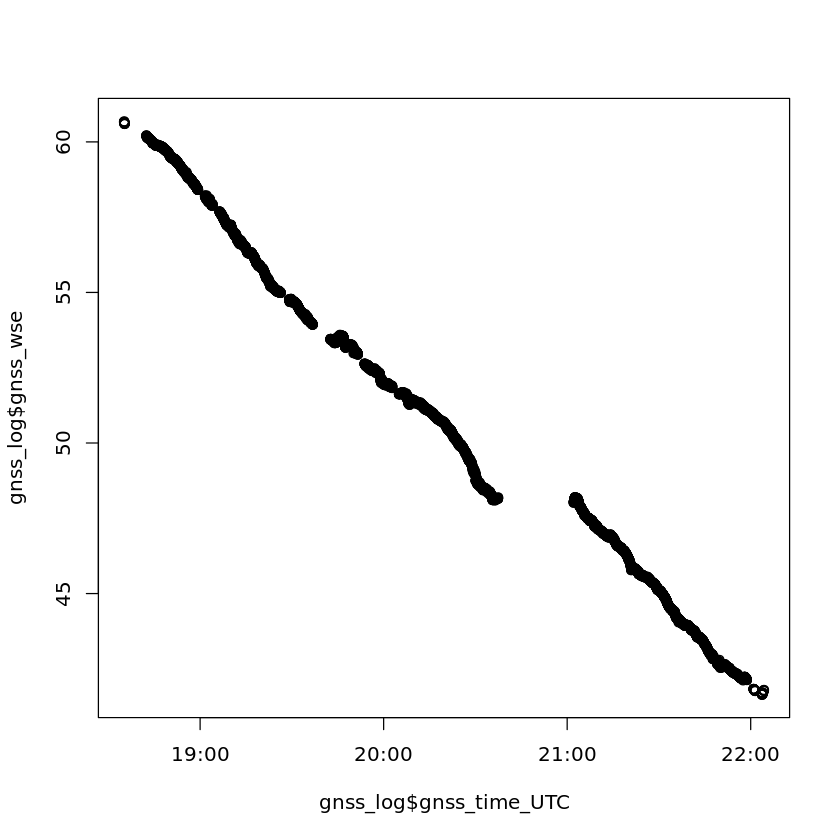

In [34]:
#create dataframes from drifts---------------------------------------------------------
#pull filename before the .csv
raw_GNSS=sub( "\\..*","", list.files(GNSS_drift_data_directory))

#pull filename before the second _
QA_QC_drifts=sub( "\\..*","",list.files(QA_QC_drift_output_directory))
flagged_drifts=sub("\\..*","",list.files(flagged_drift_output_directory))
#what raw drift data have not been munged
unmunged_drifts=setdiff(raw_GNSS,c(flagged_drifts,QA_QC_drifts))



if(!identical(unmunged_drifts,character(0))){
  source('/nas/cee-water/cjgleason/calval_toolbox/R code/create_GNSS_dataframe.R')
  # cl=makeCluster(20)

    for (i in 1:length(unmunged_drifts)){
  create_gnss_dataframe(unmunged_drifts[i],
                  gnss_drift_data_directory=GNSS_drift_data_directory,
                  output_directory=QA_QC_drift_output_directory)
        
        }
    
  # dummy=parLapply(cl=cl,unmunged_drifts,create_gnss_dataframe,
  #                 gnss_drift_data_directory=GNSS_drift_data_directory,
  #                 output_directory=QA_QC_drift_output_directory)
  # stopCluster(cl)
}

#-------------------------------------------------

In [ ]:
#munge PTs if needed------
dist_thresh=150 # 150m
time_thresh= 15*60 #minutes as seconds, centered, so 15 =30 mins total time
GNSS_sd_thresh=0.15 # 15cm how much variance do you want in the GNSS data when it is within the distance threshold?
offset_sd_thresh=0.10 #m, so 10cm. the the PT apparantly shift by more than a cm?
change_thresh_15_min=0.05#m- does it change more than 5cm in 15 minutes? that is a discontinuity in offset

#check for un-munged PT data
#pull filename before the .csv
raw_PT=sub( "\\..*","", list.files(PT_data_directory))
#pull filename before the second _
QA_QC_PTs=sub( "\\..*","",list.files(QA_QC_PT_output_directory))
flagged_PTs=sub( "\\..*","",list.files(flagged_PT_output_directory))
#what raw PT data have not been munged
unmunged_PTs=setdiff(raw_PT,c(flagged_PTs,QA_QC_PTs))
#run the PTs that are not yet munged


if(!identical(unmunged_PTs,character(0))){
  source('R code/correct_PT_to_GNSS.R')
  
  cl=makeCluster(16)
  
  dummy=parLapply(cl,unmunged_PTs,correct_pt_to_gnss,
                  pt_key_file=PT_key_file,
                  dist_thresh=dist_thresh,
                  time_thresh=time_thresh,
                  pt_data_directory=PT_data_directory,
                  gnss_drift_data_directory=QA_QC_drift_output_directory,
                  QA_QC_pt_output_directory=QA_QC_PT_output_directory,
                  flagged_pt_output_directory=flagged_PT_output_directory,
                  gnss_sd_thresh=GNSS_sd_thresh,
                  offset_sd_thresh=offset_sd_thresh,
                  change_thresh_15_min=change_thresh_15_min)
  
  stopCluster(cl)
}

#-----------------------------

In [33]:
#calculate slopes and heights from drifts within nodes and reaches------

SWORD_reach= read.csv(domain_file)
this_river_reach_IDs= as.numeric(unique(SWORD_reach$Reach_ID[!is.na(SWORD_reach$Reach_ID)]))
this_river_node_IDs= as.numeric(unique(SWORD_reach$Node_ID[!is.na(SWORD_reach$Node_ID)]))
#photo_path= 'Willamette/Watermask/Demo_output/Shapefile/'
#this_river_reach_IDs
options(warn=-1)
source('/nas/cee-water/cjgleason/calval_toolbox/R code/calculate_slope_wse_fromdrift.R')

dummy=calculate_slope_wse_fromdrift(SWORD_path=SWORD_path,
                                    drift_directory=QA_QC_drift_output_directory,
                                    PT_directory=PT_directory,
                                    output_directory=reachnode_output_directory,
                                    this_river_reach_ids=this_river_reach_IDs,
                                    this_river_node_ids=this_river_node_IDs,
                                    utm_zone=utm_zone, 
                                    buffer=buffer,
                                    rivername=rivername,
                                    reprocess_switch=reprocess_switch)

# dummy
#-----------------------------

[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am returning a double precision"
[1] "floating point, but you must be aware that this could lose precision!"
[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am returning a double precision"
[1] "floating point, but you must be aware that this could lose precision!"
[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am returning a double precision"
[1] "floating point, but you must be aware that this could lose precision!"
[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am returning a double precision"
[1] "floating point, but you must be aware that this could lose precision!"
[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am return

ERROR: Error in file(file, "rt"): cannot open the connection


In [ ]:
#calculate slopes and heights from PTs within nodes and reaches----
PT_files=paste0(QA_QC_PT_output_directory,list.files(QA_QC_PT_output_directory))
SWORD_reach= read.csv(domain_file)
this_river_reach_IDs= as.numeric(as.character(unique(SWORD_reach$reach_id)))
alongstream_error= 0.0001*200 #m error we get from the downstream slope of a reach in a node. This placeholder is a 1e-4 slope over a 200m node
crossstream_error= 0.005 #m error we get from PT not representing cross stream superelevation/noise in a node
measurement_error= 0.001 #m error we get from PT measurement itself 
source('/nas/cee-water/cjgleason/calval_toolbox/R code/calculate_slope_wse_fromPT.R')

dummy=calculate_slope_wse_fromPT(keyfile=keyfile,
                                 pt_files=PT_files,
                                 SWORD_path=SWORD_path,
                                 SWORD_reach=SWORD_reach,
                                 this_river_reach_ids=this_river_reach_IDs,
                                 alongstream_error=alongstream_error,
                                 crossstream_error=crossstream_error,
                                 measurement_error=measurement_error)
#-----------------------------

In [ ]:
#define what drift goes with what SWOT overpass--------------------
passname='fake swot pass ID'
SWOT_time_UTC=as.POSIXct('2022-07-26 21:44:47')
time_threshold_sec= 120*60 #two hour
wse_threshold_m=0.05 #within 5cm
distance_threshold_m =200 #within 200m
keyfile='Willamette/WM_Key.csv'
source('R code/select_appropriate_drift.R')

dummy=select_appropriate_drift(passname=passname,
                               swot_time_UTC=SWOT_time_UTC,
                               time_threshold_sec=time_threshold_sec,
                               wse_threshold_m= wse_threshold_m,
                               distance_threshold_m=distance_threshold_m,
                               keyfile=keyfile)
#-----------------------------

[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am returning a double precision"
[1] "floating point, but you must be aware that this could lose precision!"
[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am returning a double precision"
[1] "floating point, but you must be aware that this could lose precision!"
[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am returning a double precision"
[1] "floating point, but you must be aware that this could lose precision!"
[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am returning a double precision"
[1] "floating point, but you must be aware that this could lose precision!"
[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am return

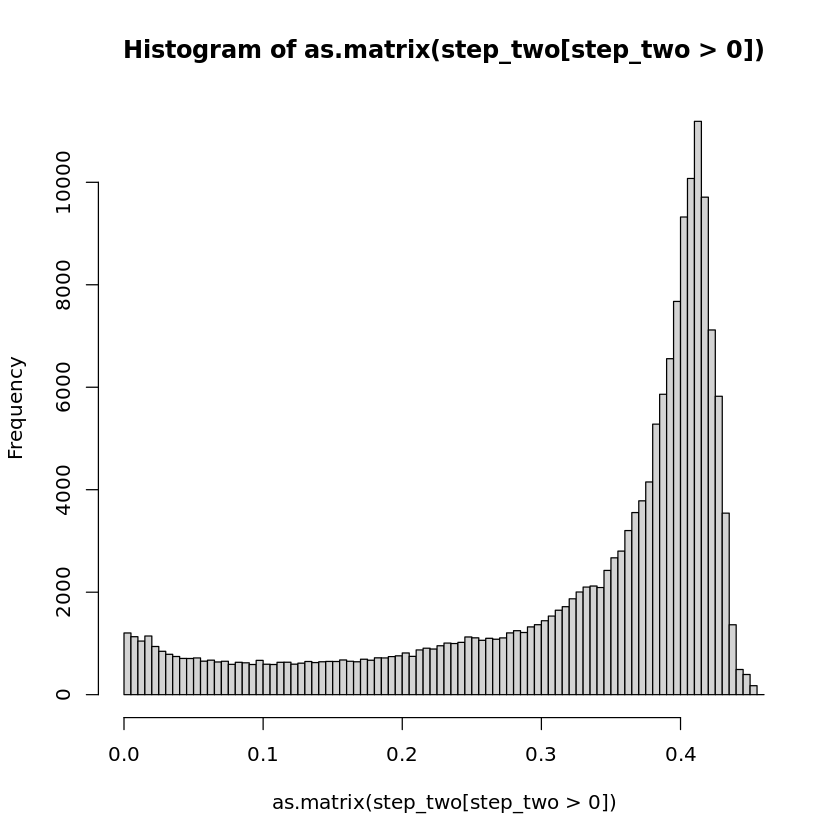

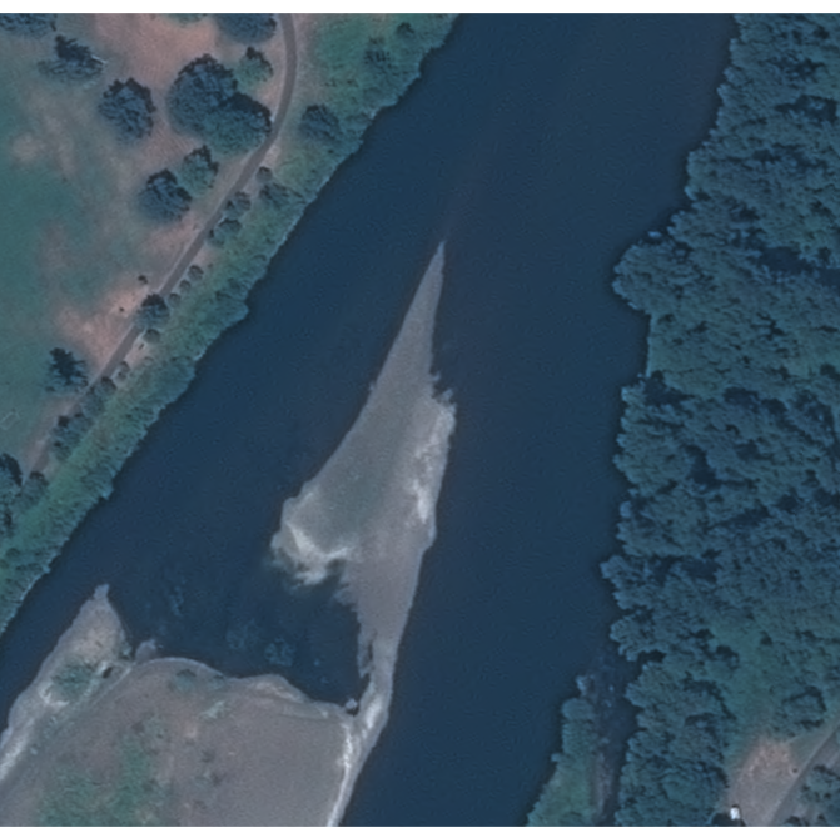

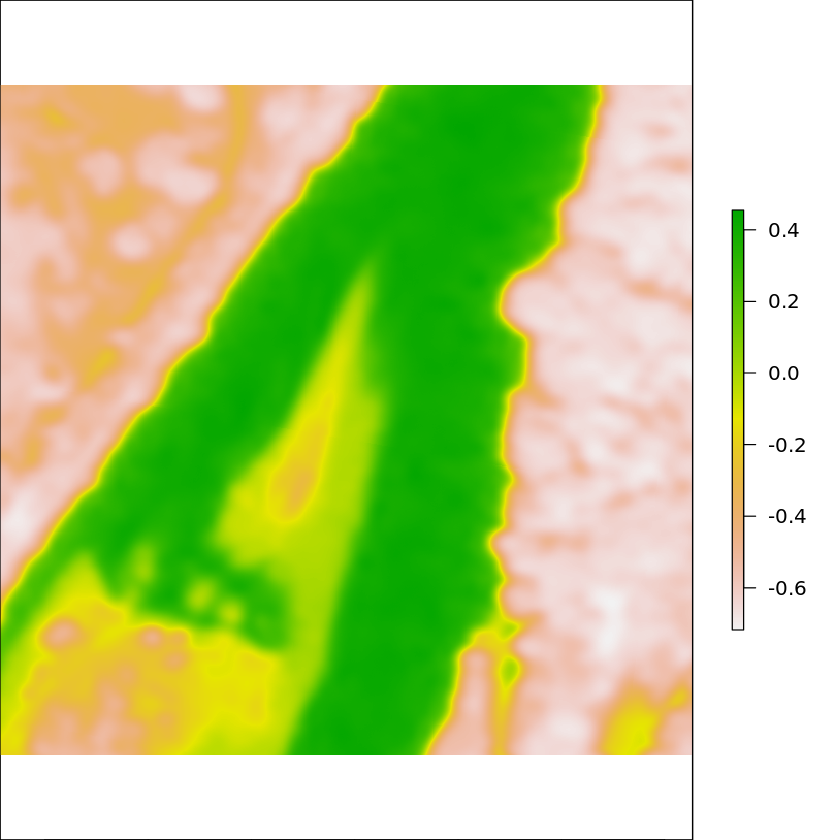

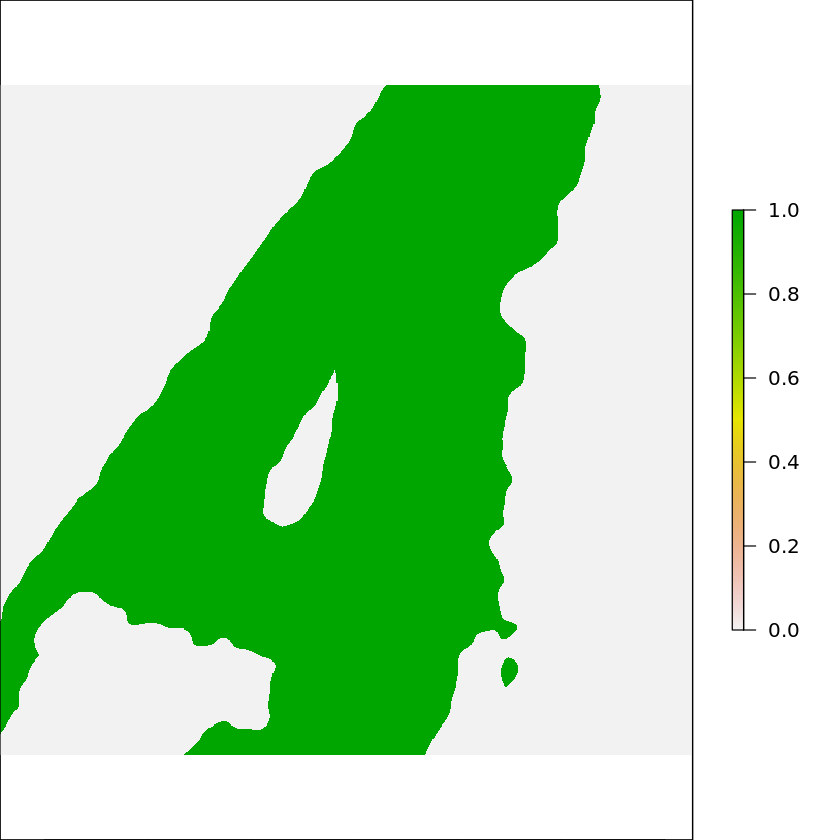

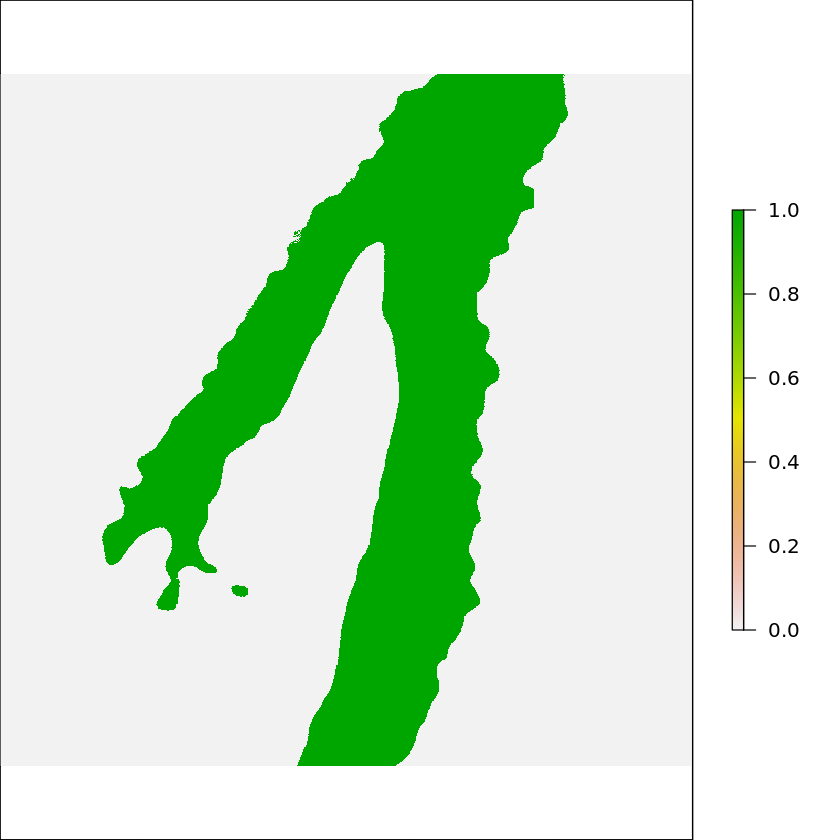

Time difference of 9.102408 secs


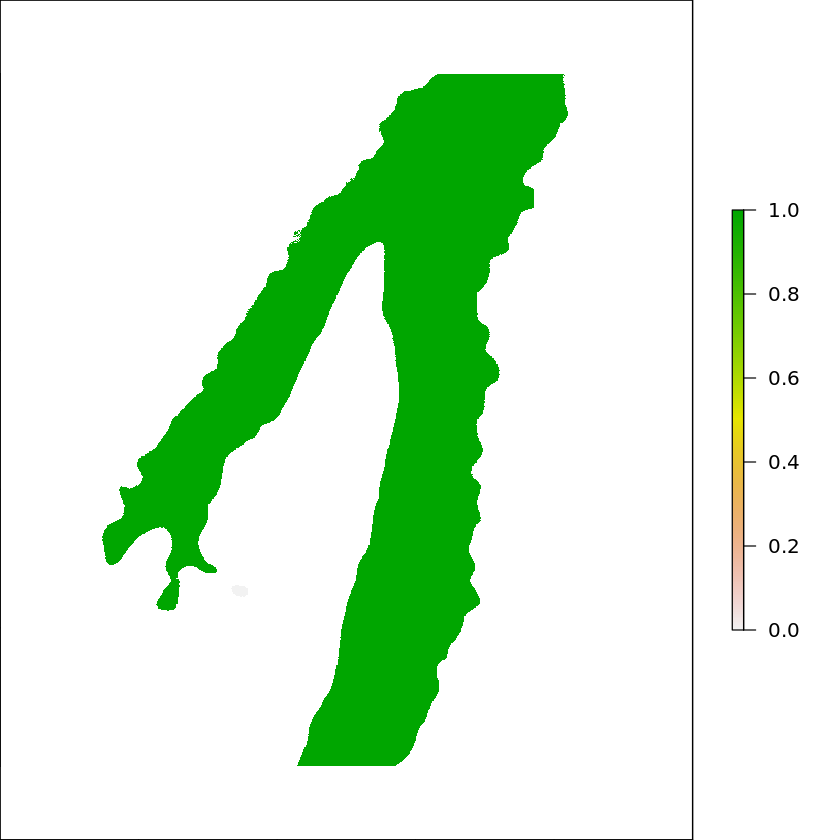

In [20]:
#calcluate areas from images------------------
a=Sys.time()

library(parallel)
source('/nas/cee-water/cjgleason/calval_toolbox/R code/calculate_area_from_imagery.R')

utm_zone = 10
#scale max width (in cases of under/overestimated or centerline offset)
scale_maxwidth = 3
datetime=as.POSIXct('2022-07-29 19:00:00')
##other parameter setting
#Threshold for water mapping
water_index_threshold = 0.2
reach_or_node='node'

#path of input image 
image_list = paste0('/nas/cee-water/cjgleason/calval/willamette_geotiffs/raw/WillametteROI/',
                    list.files('/nas/cee-water/cjgleason/calval/willamette_geotiffs/raw/WillametteROI/'))

#path of input SWORD data (netcdf)
SWORD_path='/nas/cee-water/cjgleason/SWORDv14/Reaches_Nodes/netcdf/na_sword_v11.nc'
#output dir
dir_output = '/nas/cee-water/cjgleason/calval_toolbox/Willamette/Watermask/'

# #selected reach and nodes to be processed
this_river_reach_ids <- c(78220000191,78220000181,78220000171)
this_river_node_ids <- c(78220000190011,78220000180811,78220000180661,78220000180511,
                        78220000180351,78220000180341,78220000180201,
                         78220000180191,78220000170571,78220000170401,78220000170281,78220000170161,78220000170011)

reach=c(78220000191,
        78220000181,78220000181,78220000181,78220000181,78220000181,78220000181,78220000181,
        78220000171,78220000171,78220000171,78220000171,78220000171,
        78220000191,78220000181,78220000171)
        
node=c(78220000190011, 
       78220000180811,78220000180661,78220000180511,78220000180351,78220000180341,78220000180201,78220000180191,
       78220000170571,78220000170401,78220000170281,78220000170161,78220000170011,
       'NA','NA','NA')

reach_or_node=c(rep('node',times=13),rep('reach',times=3))

# reach=c(78220000191)
        
# node=c(78220000190011)

# reach_or_node='node'


df=data.frame(reach=reach,node=node,reach_or_node=reach_or_node)
 input_list=do.call("mapply", c(list, df, SIMPLIFY = FALSE, USE.NAMES=FALSE))
#print(input_list)
#  cl=makeCluster(16)
# dummy=do.call(rbind,parLapply(cl,input_list,calculate_area_from_imagery,image_list=image_list,
#                                      utm_zone=utm_zone,
#                                      datetime=datetime,
#                                      scale_maxwidth=scale_maxwidth, 
#                                      SWORD_path=SWORD_path,
#                                      water_index_threshold=water_index_threshold,
#                                     dir_output=dir_output  ))
#  write.csv(dummy,paste0(dir_output,'CSV/','willamete_epxeriment_area_df.csv'))
# stopCluster(cl)



calculate_area_from_imagery(input_list=input_list[[1]],
                            image_list=image_list[[1]],
                                     utm_zone=utm_zone,
                                     datetime=datetime,
                                     scale_maxwidth=scale_maxwidth, 
                                     SWORD_path=SWORD_path,
                                     water_index_threshold=water_index_threshold,
                                    dir_output=dir_output  )
print(Sys.time()-a)#calcluate areas from images----


In [8]:
  
  gnss_nc=nc_open('/nas/cee-water/cjgleason/calval/Processed data/UMass/From Andy/UMass_netCDFs/SWOTCalVal_CR_GNSS_L2_Rec1_20230420T130006_20230420T170835_20230426T004903.nc')
  # wse- water surface height wrt geoid. All JPL corrections applied
  # longitude- longitude
  # latitude- latitute
  # time_tai - time in some wierd TAI format. It is seconds since January 1 2000 at midnight WITHOUT leap seconds.
  #motion flag- 0,1, or 2. COdes 0 and 1 incidate no good data, keep only 2
  #surface type flag - 10, 11, or 12. Simialrly, only code 12 incicates quality data
  
  
  Lat=ncvar_get(gnss_nc,'latitude')
  Lon=ncvar_get(gnss_nc,'longitude')
  gnss_wse= ncvar_get(gnss_nc,'wse')
  gnss_time_tai=ncvar_get(gnss_nc,'time_tai')
  gnss_motion_flag  =ncvar_get(gnss_nc,'motioncode_flag')
  gnss_surf_flag  =ncvar_get(gnss_nc,'surfacetype_flag')
  gnss_ellipsoid= paste(ncatt_get(gnss_nc,0,'ellipsoid_semi_major_axis')$value,ncatt_get(gnss_nc,0,'ellipsoid_flattening')$value,sep=",")
  gnss_uncertainty=ncvar_get(gnss_nc,'position_3drss_formal_error')
  
  Info_event=ncvar_get(gnss_nc,'infoEventDescription')
  Info_event_start=ncvar_get(gnss_nc,'infoEventStartTime')
  Info_event_end=ncvar_get(gnss_nc,'infoEventEndTime')
  

  
  Info_df=data.frame(Event_code=Info_event, Event_start= Info_event_start, Event_end=Info_event_end)%>%
    mutate(Event_start_UTC = as.POSIXct(Event_start,origin='2000-01-01 00:00:00',tz='UTC'))%>%
    mutate(Event_end_UTC = as.POSIXct(Event_end,origin='2000-01-01 00:00:00',tz='UTC' ))%>%
    select(-Event_end,-Event_start)%>%
    #add 1 minutes to the event codes
    mutate(Event_start_UTC=Event_start_UTC-1*60)%>%
    mutate(Event_end_UTC=Event_end_UTC+1*60)#%>%
    # filter(Event_code=='Bridge' | Event_code == 'Powerlines' | Event_code=='bridge' |
    #        Event_code=='Bridges' |Event_code=='bridges'| Event_code == 'Powerline'|
    #        Event_code == 'powerlines' | Event_code == 'powerline' | Event_code == 'Birdge')

Info_df
  
  gnss_log=data.frame(gnss_Lat=Lat,gnss_Lon=Lon,gnss_wse=gnss_wse,gnss_time_tai=gnss_time_tai,gnss_uncertainty_m=gnss_uncertainty,
                      gnss_surf_flag=gnss_surf_flag,gnss_motion_flag=gnss_motion_flag)%>%
    #R's native POSIXCT also doesn't have leap seconds, so we're good
    mutate(gnss_time_UTC = as.POSIXct(gnss_time_tai,origin='2000-01-01 00:00:00',tz='UTC' ))%>%
    #need this to join, but let's preserve original
    filter(gnss_surf_flag==12)%>%
    filter(gnss_motion_flag==2)%>%
    mutate(gnss_ellipsoid=gnss_ellipsoid)%>%
    #filter for self ID uncertainty at 5cm
    filter(gnss_uncertainty_m<0.05)%>%
    mutate(drift_id= 'bonkbonk')

  #need to recurse this, so a for loop is actually needed!
if (nrow(Info_df)>0){
  for(i in 1:nrow(Info_df)){
    gnss_log=filter(gnss_log, gnss_time_UTC >= Info_df$Event_end_UTC[i] | gnss_time_UTC <= Info_df$Event_start_UTC[i] )
    
  }
}

head(gnss_log)


Event_code,Event_start_UTC,Event_end_UTC
<chr>,<dttm>,<dttm>
"AntennaOffset(meas1,meas2,meas3,avg,stddev): -1.33, -1.327, -1.324, -1.327, 0.002",2023-04-20 12:59:06,2023-04-20 13:01:06
calculating antennae offset at slow(-1.327) and on plane (-1.519),2023-04-20 13:51:00,2023-04-20 13:55:34
Bridge,2023-04-20 14:08:57,2023-04-20 14:11:03
Bridge,2023-04-20 14:14:57,2023-04-20 14:17:01
Powerline,2023-04-20 14:29:12,2023-04-20 14:31:16
Bridge,2023-04-20 14:30:13,2023-04-20 14:32:16
Bridge,2023-04-20 14:35:58,2023-04-20 14:37:59
Bridge,2023-04-20 14:39:28,2023-04-20 14:41:42
Bridge,2023-04-20 14:41:52,2023-04-20 14:44:06


,gnss_Lat,gnss_Lon,gnss_wse,gnss_time_tai,gnss_uncertainty_m,gnss_surf_flag,gnss_motion_flag,gnss_time_UTC,gnss_ellipsoid,drift_id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dttm>,<chr>,<chr>
1,41.84804,-72.62472,2.711411,735314347,0.02370442,12,2,2023-04-20 13:59:07,"6378137,0.00335281066474748",bonkbonk
2,41.84811,-72.62471,2.700064,735314348,0.02370467,12,2,2023-04-20 13:59:08,"6378137,0.00335281066474748",bonkbonk
3,41.84817,-72.62470,2.722113,735314349,0.02370491,12,2,2023-04-20 13:59:09,"6378137,0.00335281066474748",bonkbonk
4,41.84824,-72.62468,2.695715,735314350,0.02370515,12,2,2023-04-20 13:59:10,"6378137,0.00335281066474748",bonkbonk
5,41.84832,-72.62467,2.682420,735314351,0.02370539,12,2,2023-04-20 13:59:11,"6378137,0.00335281066474748",bonkbonk
6,41.84840,-72.62466,2.694609,735314352,0.02370563,12,2,2023-04-20 13:59:12,"6378137,0.00335281066474748",bonkbonk


In [4]:
library(ncdf4)